[View in Colaboratory](https://colab.research.google.com/github/SwapnilSParkhe/Project-Image_Caption_Generation/blob/master/Testing_Model.ipynb)

# Testing Model

**Checking CPU/GPU status**

In [24]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 18340731813828155447]

## Generating description for an image

**Uploading relevant files (tokenizer and best model)**

In [10]:
from google.colab import files

#Upload tokenizer (which was based on train data)
files.upload()   #upload files 

#Upload best model trained
files.upload()   #upload files


Saving tokenizer.pkl to tokenizer.pkl


Saving best_model_weights.h5 to best_model_weights.h5


**Importing required files **

In [1]:
from pickle import load
from keras.models import load_model

tokenizer=load(open('tokenizer.pkl','rb'))
best_model=load_model('best_model_weights.h5')

Using TensorFlow backend.


**Uploading and Preprocessing the uploaded image**

In [37]:
#Upload a photo for which desc needs to be generated
from google.colab import files
my_Image=files.upload()

#Extracting features of uploaded image (Leveraging VGG16)
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
def ImageFeature_Extractor(ImageName): 
    #Re-structuring the VGG model as per requirements
    model=VGG16(weights="imagenet")  #Loading the model
    model.layers.pop()  #Restructing model (retain penultimate FCC-4096)
    model=Model(inputs=model.inputs, outputs=model.layers[-1].output)
    print(model.summary())  #Summarizing our re-structured model

    #Extracting features from image (jpg) using restructured model   
    image=load_img(ImageName,target_size=(224,224)) #loading img aptly
    image=img_to_array(image)   #converting PIL image to array
    image=image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))  
    image=preprocess_input(image)   # preprocessing of img for VGG
    image_feature=model.predict(image,verbose=0)   #getting img features

    return image_feature

img_feat=ImageFeature_Extractor(list(my_Image.keys())[0])

Saving 495341977_b27279f962.jpg to 495341977_b27279f962.jpg
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (Max

**Setting Up our caption generator (funcitons from development phase)**

In [0]:
#Mapping an integer prediction back to a word
#Note: Using the same tokeniser used for train data
def intID_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

#Generating a desc for an image using trained model
from numpy import argmax
from keras.preprocessing.sequence import pad_sequences
def generate_desc(model, tokenizer, image, max_length):
    in_text='startseq'   #seeding the generation process
    for i in range(max_length):
        seq=tokenizer.texts_to_sequences([in_text])[0] #encoding txt2int
        seq=pad_sequences([seq], maxlen=max_length) #padding seq
        pred=model.predict([image, seq], verbose=0) #predict next word
        pred=argmax(pred)   #prob to integer ID conversion
        word=intID_to_word(pred, tokenizer) #intID to word mapping
        if word is None:
            break   #stop if cant map word
        in_text += ' ' + word  #append as input to generate next word
        if word=='endseq':
            break   #stop if end of seq
    return in_text

**GET SET GO**

startseq two dogs are running through the grass endseq


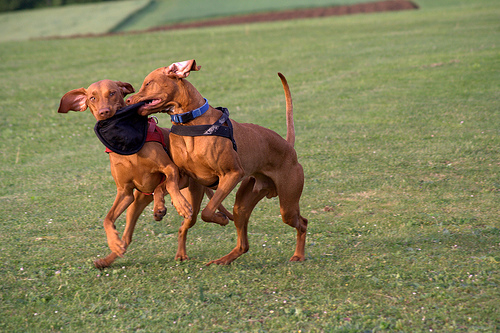

In [39]:
#Generating and priting caption
#Note: Hard-coding max_length for caption generator
max_length=33
print(generate_desc(best_model, tokenizer, img_feat, max_length))

#Showing Image
from IPython.display import Image 
Image(filename=list(my_Image.keys())[0])

## POTENTIAL ENHANCEMENTS

**Reducing the vocabulary**

In [65]:
#Reducting vocabulary by removing english stop words
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')

#Removing english stopwords from the list 
word_tokens=[word_tokenize(desc) for desc in ["Spain is my favourite country", "I would love to visit Spain"]]
stopwords_eng = list(set(stopwords.words('english')))
tokens_engSW = [w for wt in word_tokens for w in wt if not w in stopwords_eng]
tokens_engSW

[nltk_data] Downloading package stopwords to /content/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /content/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['Spain', 'favourite', 'country', 'I', 'would', 'love', 'visit', 'Spain']